In [4]:
!pip install gym

In [6]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

In [7]:
torch.manual_seed(51)

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
!pip install quandl

# Retrieve data from Quandl

Don't bother with this step if the data's already saved from the Pickle below.

In [0]:
import quandl
quandl.ApiConfig.api_key = "rXXdzdztRDxDhmk5nHvH"
apl_stock=quandl.get('WIKI/AAPL', start_date="2014-01-01", end_date="2018-08-20", )
msf_stock=quandl.get('WIKI/MSFT', start_date="2014-01-01", end_date="2018-08-20")
apl_open = apl_stock["Open"].values
apl_close = apl_stock["Close"].values
msf_open = msf_stock["Open"].values
msf_close = msf_stock["Close"].values

In [0]:
msf_stock.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2014-01-02,37.350,37.40,37.10,37.16,30632200.0,0.0,1.0,33.704254,33.749373,33.478656,33.532800,30632200.0
2014-01-03,37.200,37.22,36.60,36.91,31134800.0,0.0,1.0,33.568895,33.586943,33.027461,33.307202,31134800.0
2014-01-06,36.850,36.89,36.11,36.13,43603700.0,0.0,1.0,33.253059,33.289154,32.585290,32.603338,43603700.0
2014-01-07,36.325,36.49,36.21,36.41,35802800.0,0.0,1.0,32.779304,32.928198,32.675529,32.856007,35802800.0
2014-01-08,36.000,36.14,35.58,35.76,59971700.0,0.0,1.0,32.486028,32.612362,32.107024,32.269454,59971700.0


## Examine the data

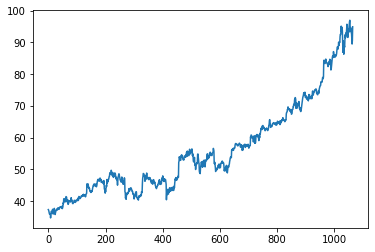

In [0]:
plt.plot(range(0, len(msf_open)), msf_open)

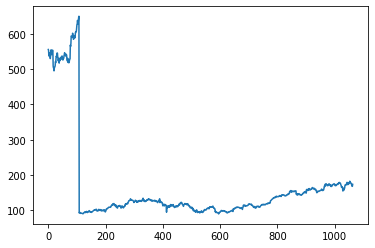

In [0]:
plt.plot(range(0, len(apl_open)), apl_open)

## Oof! What's happened?

Turns out that on 9 June 2014, AAPL stock was split in the ratio of 1:7. So, I'll divide everything before element 108 in the stock array by 7 to correct for this.

In [0]:
apl_open[:108] /= 7

In [0]:
apl_close[:108] /= 7

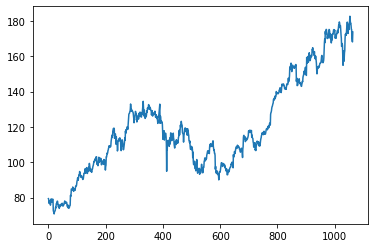

In [0]:
plt.plot(range(0, len(apl_open)), apl_open)

## Looks better, now remove the general upwards trend.

Now I'm going to de-trend the data. Otherwise MSFT and AAPL are on completely different scales and we could hardly expect the AI to learn how to trade apples and oranges together. Additionally, we want the AI to learn the fundamentals of the stock signal - buy if it's going to rise. If we didn't remove the trend, maybe it'd only learn to buy at the start and hold til the end since a general upwards trend happens.

SciPy's signal processing module has a function that fits a linear least-squares model to the data and subtracts it for us.

In [0]:
from scipy import signal

In [0]:
msf_open = signal.detrend(msf_open)
msf_close = signal.detrend(msf_close)

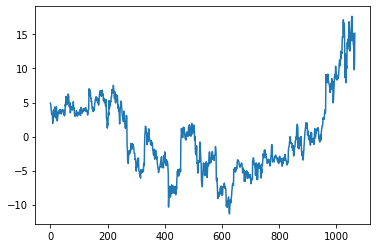

In [0]:
plt.plot(range(0,len(msf_open)), msf_open)

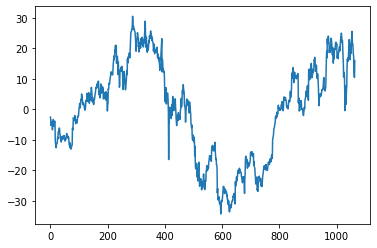

In [0]:
apl_open = signal.detrend(apl_open)
apl_close = signal.detrend(apl_close)
plt.plot(range(0, len(apl_open)), apl_open)

## Negative values?

It doesn't make sense to buy a share at a negative value. But since the model will learn to maximize reward, we can just shift it up by a constant number so it's always positive.

In [0]:
print(apl_open.min())
print(apl_close.min())
print(msf_open.min())
print(msf_close.min())

-34.32168425572115
-34.44741197813629
-11.36577530568286
-11.83460285153199


Choose 35

In [0]:
apl_open += 35.
apl_close += 35.
msf_open += 35.
msf_close += 35.

## Save the transformed data

In [0]:
import pickle
with open("aplmsfopenclose.pkl", "wb+") as f:
    pickle.dump({"ao":apl_open, "ac": apl_close, "mo": msf_open, "mc": msf_close}, f)

## If the data's already saved, skip the above and load it here instead

In [0]:
import pickle
with open("aplmsfopenclose.pkl", "rb") as f:
    d = pickle.load(f)
apl_open = d["ao"]
apl_close = d["ac"]
msf_open = d["mo"]
msf_close = d["mc"]

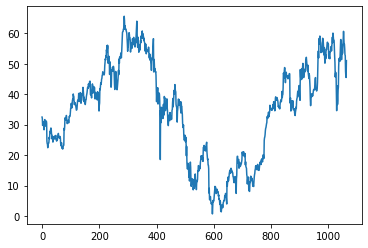

In [0]:
plt.plot(range(0,len(apl_open)), apl_open)

# Build the environment

* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 10% brokerage fee

In [0]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, \
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * msf_close[self.cur_timestep]) + self.state[2]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [apl_open[step], msf_open[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_open[0], msf_open[0]]
        apl5 = apl_open[step-5:step].mean()
        msf5 = msf_open[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                    cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]       
        self.done = False
        return self.state

In [0]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        
    def forward(self, x):

        x = torch.tensor(x).float().cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [0]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [0]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 60

policy_loss = []
value_loss = []
def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item()).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r]).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    policy_loss.append(sum(policy_losses))
    value_loss.append(sum(value_losses))
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]

rewards = []
running_reward = 0
for episode in range(0, 200):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    rewards.append(running_reward)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 6750.1, finished at 6707.2 because bankrupted self @ t=381, last reward 386.8, running reward 6.4
Episode 60: started at 9386.9, finished at 6144.3 because bankrupted self @ t=685, last reward -1071.5, running reward 323.5
Early Stopping: 13039


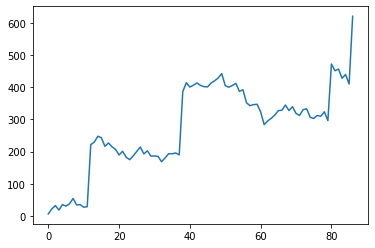

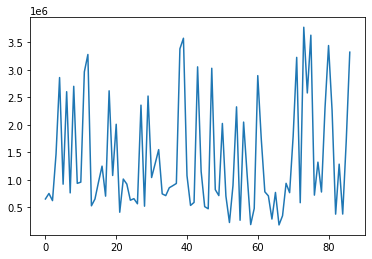

In [0]:
plt.plot(rewards)
plt.show()
plt.plot(value_loss)
plt.show()

## Let's see how it does in practice, on the training data

In [0]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)

total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 1000

for j in range(num_goes):
    env.reset()
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    total_profits += (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value
    if reward_this_go == -1e8:
        failed_goes += 1
    else:
        total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format(total_profits / num_goes))
    print("Avg % profit per finished game: {}".format(total_profits / (num_goes - failed_goes)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Failed goes: 969 / 1000, Avg Rewards per successful game: 10180.8173828125
Avg % profit per game: -0.017048891633749008
Avg % profit per finished game: -0.549964189529419


## And here's how a sample trading run might look

In [10]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

NameError: name 'TradingEnvironment' is not defined

In [0]:
apl_open_orig = apl_stock["Open"].values
apl_close_orig = apl_stock["Close"].values
msf_open_orig = msf_stock["Open"].values
msf_close_orig = msf_stock["Close"].values
apl_open_orig[:108] /= 7
apl_close_orig[:108] /= 7

In [0]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break

Starting portfolio value: 8306.9296875
Starting portfolio value: 8060.107421875


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Starting portfolio value: 7153.2041015625
Starting portfolio value: 7127.91796875
Starting portfolio value: 8283.2138671875
Starting portfolio value: 7845.923828125
Starting portfolio value: 7804.208984375
Starting portfolio value: 7546.134765625
Starting portfolio value: 7750.60498046875
Starting portfolio value: 7743.353515625
Starting portfolio value: 9163.185546875
Starting portfolio value: 7612.7822265625
done, have 98.0 aapl and 99.0 msft and 104.59992980957031 cash
Finished portfolio value 9534.38671875


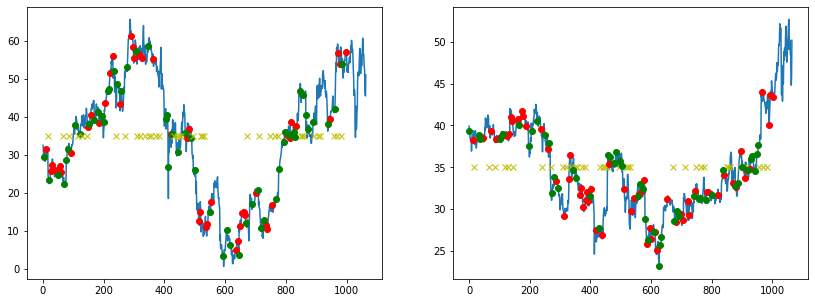

In [0]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open)), apl_open)
msf.plot(range(0, len(msf_open)), msf_open)
apl.plot(ba_action_times, bought_apl_at, "ro")
apl.plot(sa_action_times, sold_apl_at, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at, "ro")
msf.plot(sm_action_times, sold_msf_at, "go")

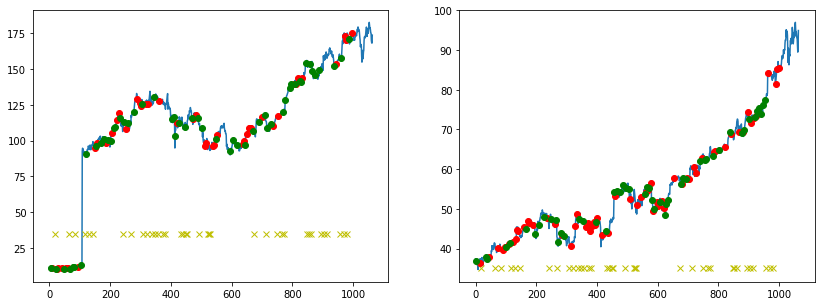

In [0]:
plt.figure(1, figsize=(14,5))
apl = plt.subplot(121)
msf = plt.subplot(122)
apl.plot(range(0, len(apl_open_orig)), apl_open_orig)
msf.plot(range(0, len(msf_open_orig)), msf_open_orig)
apl.plot(ba_action_times, bought_apl_at_orig, "ro")
apl.plot(sa_action_times, sold_apl_at_orig, "go")
apl.plot(n_action_times, nothing_at, "yx")
msf.plot(n_action_times, nothing_at, "yx")
msf.plot(bm_action_times, bought_msf_at_orig, "ro")
msf.plot(sm_action_times, sold_msf_at_orig, "go")

In [0]:
print(policy_losses)

NameError: ignored